# Powtórzenie:
* Idea uczenia maszynowego
* główna idea SVM
* separowalność liniowa
* funkcje jądrowe
* problem pierwotny i dualny, Lagrangian
* minimalna optymalizacja osiowa



In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image

# Drzewa decyzyjne

# Wstęp

* Drzewa decyzyjne to popularne narzędzia do “data mining” 
* Nadają się szczególnie dobrze do klasyfikacji, ale można je też przystosować do problemów regresji. 
* My skupimy się na ich zastosowaniach w klasyfikacji (podjęcia decyzji).

# Cechy algorytmów drzewiastych:
* łatwe do zrozumienia
* generują wyjście, które jest łatwo interpretować
* są algorytmem typu “white box” - można łatwo wizualizować wiedzę, której wyuczył się algorytm
* mogą działać zarówno z danymi numerycznymi/ciągłymi jak i kategorycznymi/dyskretnymi
* algorytmy są typu “konstrukcyjnego poszukiwania” - drzewa “rosną” dopasowując się do danych 
* dość łatwe w użyciu -> niezbyt dużo parametrów do dopasowywania zanim uda się z nich wycisnąć coś użytecznego
* dobrze skalowalne
* najczęściej uczone są “wsadowo” (batch mode)

# Jak można wyobrażać sobie drzewo decyzyjne 
* składa się z węzłów
* w danym węźle testowana jest wartość jednej cechy z przykładu uczącego 
* węzeł ma rozgałęzienia zależne od wyniku testu

## Przykład z decyzją o spacerze 
* Załóżmy, że chdzimy na spacer w zależności od pogody. 
* Zobaczmy jak może wyglądać drzewo opisujące podejmowanie decyzji o spacerze. 
* Drzewo takie budujemy w oparciu o zastaw wcześniejszych obserwacji różnych parametrów (cech) i podjętych decyzji. Innymi słowy mamy **zbiór uczący**.
* cechy (wejście): (Zachmurzenie{słonecznie, pochmurno, pada}, temperatura, wilgotność, wiatr)
* wyjście: tak/nie

![](1024px-Drzewo1.svg.png)

* cechy, np. temperatura, nie musi być istotna
* nie wszystkie cechy muszą być wykorzystane w drzewie decyzyjnym, może to wynikać z tego, że cechy są skorelowane/redundantne albo po prostu okazać się nieistotne dla problemu
* jednym z ważnych pytań, które tu się pojawiają jest to w jakiej kolejność wybierać cechy -> intuicja: od najbardziej informatywnych, tych które najszybciej prowadzą do decyzji
* jeśli cechy są ciągłe to można wprowadzić próg -> np. wilgotność (próg =75%) , wiatr(próg 20km/h)

# Podział przestrzeni cech
* W drzewach decyzyjnych granice między klasami mają postać hiperpowierzchni równoległych do osi cech 

/var/folders/1t/qbjskh415rz70kx6_0rww8680000gp/T/ipykernel_5056/1411382366.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i], cmap=plt.cm.Paired)


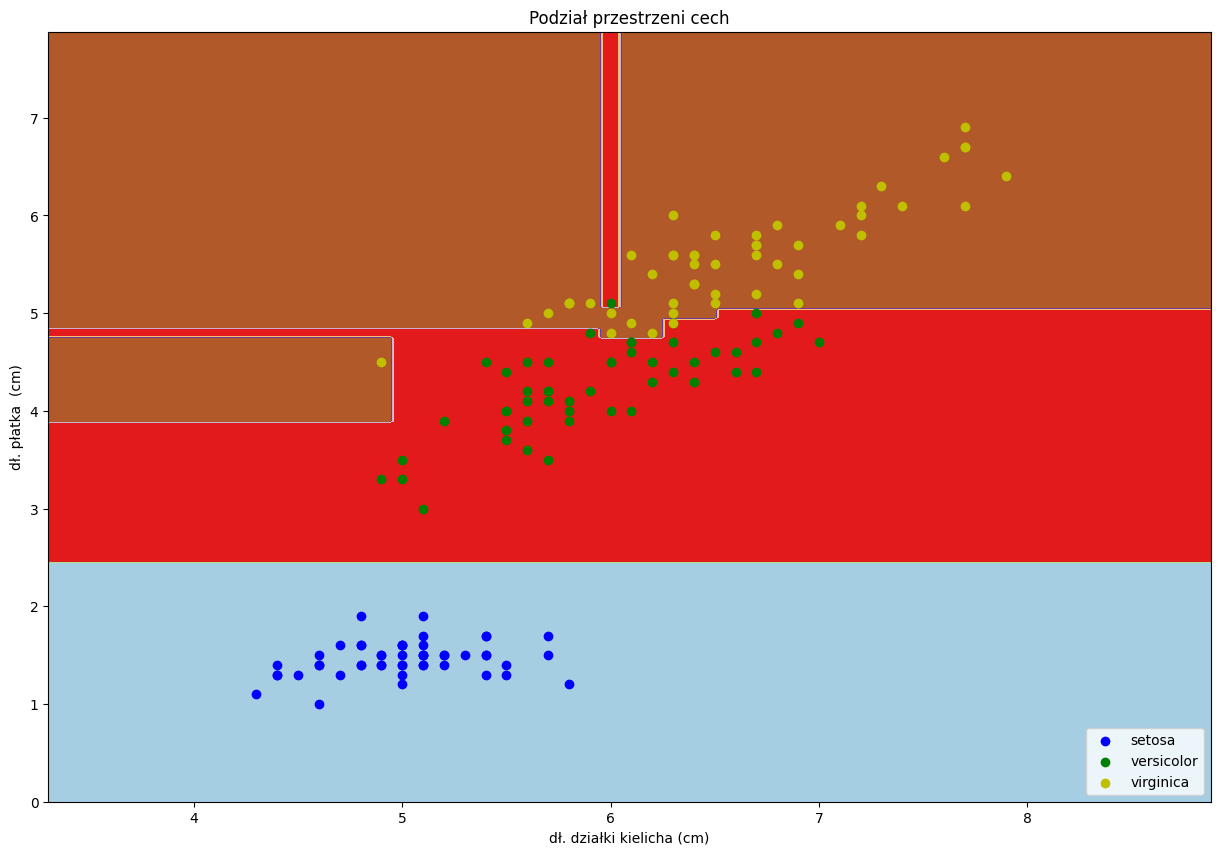

In [3]:
# Parameters
n_classes = 3
plot_colors = "bgy"
plot_step = 0.02

# Load data
iris = load_iris()
iris.feature_names = ['dł. działki kielicha (cm)', 'szer. działki kielicha (cm)', 'dł. płatka  (cm)', 'szer. płatka (cm)']
pair = [0,2]
X = iris.data[:, pair]
y = iris.target

# Train
clf = DecisionTreeClassifier().fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize = (15,10))
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.xlabel(iris.feature_names[pair[0]])
plt.ylabel(iris.feature_names[pair[1]])
plt.axis("tight")

    # Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i], cmap=plt.cm.Paired)
plt.title("Podział przestrzeni cech")
plt.legend(loc='lower right')
plt.show()


> ciężko jest nauczyć separacji klas, które na płaszczyźnie są separowane pochyłą prostą

* mając dużo danych można taką prostą aproksymować wieloma schodkami (przykład z podziałem przestrzeni 2D na prostokąty )
* w rzeczywistych zastosowaniach, gdy mamy wielowymiarowe cechy a dane są dość rzadkie, zwykle da się poprowadzić hiperpowierzchnie

## Czy można wyuczyć drzewo dowolnej funkcji logicznej?

* tak bo funkcje logiczne można reprezentować za pomocą tablic prawdy (matryc logicznych)


|<font size="20"> A </font>| <font size="20"> B </font>| <font size="20"> A or B </font>|
|---|---|:------:|
| <font size="20"> 0</font> | <font size="20"> 0</font> |  <font size="20">   0   </font>|
|<font size="20">  0 </font>| <font size="20"> 1</font> |   <font size="20">  1   </font>|
|<font size="20">  1 </font>| <font size="20"> 0 </font>|   <font size="20">  1  </font> |
|<font size="20">  1 </font>| <font size="20"> 1 </font>|   <font size="20">  1   </font>|


<img src="Drzewo_OR.png" width=800>

# Jak uczyć drzewo?

## Zarys algorytmu
* Załóżmy, że mamy kryterium $S$, które powie jak bardzo istotna jest dana cecha $c$ (To kryterium, to funkcja $S(c)$, która jest tym większa im bardziej istotna jest cecha)
* zaczynamy od korzenia i pełnego zbioru danych 
  * obliczamy $\arg \max_c S(c)$
  * na razie załóżmy, że cecha c jest logiczna: 0 lub 1, 
     * jeśli wartość wybranej cechy jest 0 to idziemy na lewo (i zostaje nam tylko pewien podzbiór danych, które mają taką właściwość) 
     * w przeciwnym razie (jeśli 1) to idziemy na prawo (i też pozostaje nam podzbiór - pozostała część)
     * w tym miejscu mówimy sobie, że ten podzbiór, który nam pozostał to cały zbiór -> rekurencja
     * rekurencyjnie podążamy tak długo aż:
       * zostaje nam podzbiór, który należy tylko do jednej klasy
       * nie mamy już cech, którymi można by zróżnicować przykłady

W pseudokodzie wygląda to tak:
* Oznaczenia:
  * `D` - dane treningowe
  * `x` - wektor wszystkich cech
  * `x_j` - pojedyncza cecha, j-ta współrzędna wektora cech
```
HodujDrzewo(D)
    S = D
 	if ( y=0 dla wszystkich {x,y} w S ) return nowyLiść(0)
 	elseif ( y=1 dla wszystkich  {x,y} w S ) return nowyLiść(1) 
 	else
        wybierz najlepsze  x_j
        S_0 = wszystkie {x,y} w S dla których x_j = 0
        S_1 = wszystkie {x,y} w S dla których x_j = 1
        return nowyWęzeł( x_j, HodujDrzewo(S_0), HodujDrzewo(S_1))
```

## Jak wybrać najlepszą cechę?

* wybrać tą cechę, która wzięta pod uwagę sama daje najmniejszy błąd przewidywania na zbiorze uczącym 
  * taka cecha, że jeśli podzielimy wg. niej to mamy najmniejszą sumę błędów w lewej i prawej gałęzi)
<html>
<body>


<table class="table table-striped table-bordered" style='font-family:"Courier New", Courier, monospace; font-size:100%' >
    
<thead>
<tr>
<th style="text-align:center" >przykład</th>
<th style="text-align:center">x1</th>
<th style="text-align:center">x2</th>
<th style="text-align:center">x3</th>
<th style="text-align:center">y</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:center">1</td>
<td style="text-align:center">0</td>
<td style="text-align:center">0</td>
<td style="text-align:center">0</td>
<td style="text-align:center">1</td>
</tr>
<tr>
<td style="text-align:center">2</td>
<td style="text-align:center">0</td>
<td style="text-align:center">0</td>
<td style="text-align:center">1</td>
<td style="text-align:center">0</td>
</tr>
<tr>
<td style="text-align:center">3</td>
<td style="text-align:center">0</td>
<td style="text-align:center">1</td>
<td style="text-align:center">0</td>
<td style="text-align:center">1</td>
</tr>
<tr>
<td style="text-align:center">4</td>
<td style="text-align:center">0</td>
<td style="text-align:center">1</td>
<td style="text-align:center">1</td>
<td style="text-align:center">1</td>
</tr>
<tr>
<td style="text-align:center">5</td>
<td style="text-align:center">1</td>
<td style="text-align:center">0</td>
<td style="text-align:center">0</td>
<td style="text-align:center">0</td>
</tr>
<tr>
<td style="text-align:center">6</td>
<td style="text-align:center">1</td>
<td style="text-align:center">0</td>
<td style="text-align:center">1</td>
<td style="text-align:center">1</td>
</tr>
<tr>
<td style="text-align:center">7</td>
<td style="text-align:center">1</td>
<td style="text-align:center">1</td>
<td style="text-align:center">0</td>
<td style="text-align:center">0</td>
</tr>
<tr>
<td style="text-align:center">8</td>
<td style="text-align:center">1</td>
<td style="text-align:center">1</td>
<td style="text-align:center">1</td>
<td style="text-align:center">0</td>
</tr>
</tbody>
       
</table>
   
</body>
</html>
   


* Podział wzg. X1 (jeśli x1=0 to y = 1, jeśli x1=1 to y = 0) dałby łącznie 1+1 =2 błędy

* Podział wzg. X2 (jeśli x2=0 to y = 1, jeśli x2=1 to y = 0) dałby łącznie 2+2 = 4 błędy
* Podział wzg. X3 (jeśli x3=0 to y = 1, jeśli x3=1 to y = 0) dałby łącznie 2+2 = 4 błędy

Podział wzg. ilości błędów może nie być optymalny, 
* NP-zupełny problem aby znaleźć najmniejsze drzewo dla konkretnych danych- > trzeba posługiwać się heurystykami
* warto skorzystać z miar dostarczanych przez teorię informacji

### Krótkie przypomnienie z teorii informacji
Mamy monetę, która ma nierówne prawdopodobieństwa:
* P(V=0) = 0.2
* P(V=1) = 0.8

(V - zmienna z rozkładu Bernouliego)

Jak bardzo się zdziwimy, dowiadując się, że zmienna V ma jakąś konkretną wartość?
* bardziej zdziwieni będziemy widząc wartość mniej prawdopodobną
* jeśli wynik zawsze byłby 1 to jaka powinna być wartość funkcji mierzącej nasze zdziwienie? (0)
* jeśli otrzymalibyśmy wynik niemożliwy, to nasze zdziwienie powinno być nieskończone

Te warunki spełnia: 
$\qquad$ $S(V=v) = -\log P(V=v)$

#### Entropia
* Entropia to średnie zdziwienie (wartość oczekiwana zdziwienia)
$\qquad$ $H(V) = \sum_{v=0}^1 -P(V=v)\log P(V=v)$
* Entropia może być miarą niepewności

Dla zmiennej z rozkładu Bernouliego entropia wygląda tak:


$\qquad$ $H(V) = p*\log_2(p) + (1-p)*\log_2(1-p)$

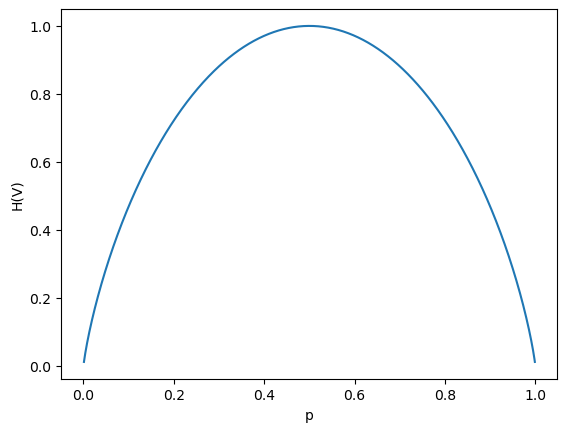

In [3]:
p = np.arange(0.001, 1, 0.001)
plt.plot(p, -p*np.log2(p) - (1-p)*np.log2(1-p))
plt.xlabel('p')
plt.ylabel('H(V)')
plt.show()

Ważne jest to, że kształt wykresu entropii od  P jest gładką funkcją wypukłą i ma gdzieś maksimum
- inna funkcja o podobnych własnościach to np GINI (https://pl.wikipedia.org/wiki/Współczynnik_Giniego )- używana przez statystyków: 

$\qquad$ $\sum_k P(V=k)(1-P(V=k)) $, 

gdzie k to klasa

#### Informacja wzajemna (Mutual information)
Informacja wzajemna pomiędzy dwiema zmiennymi losowymi to redukcja entropii  jednej  z nich (A) kiedy poznamy drugą (B):

$\qquad$ $I(A;B) = H(A)-\sum_b P(B=b)\cdot H(A|B=b)$

> Innymi słowy mierzy ona redukcję niepewności o przynależności do klasy jeśli znamy jedną z cech.

* informacja wzajemna jest dobrą miarą do wskazania, którą z cech należy użyć w danym kroku konstrukcji drzewa, bo użycie tej cechy, która ma największa informacje wzajemną z klasami najbardziej zredukuje naszą niepewność.
* można łatwo na obrazku pokazać że funkcja o takim kształcie jak entropia (wykres Entropia(P) ) - ze względu na jej wypukły kształt podział zbioru na dwie części zawsze obniża średnią entropię.

![](zmniejszanie_entropii.png)

# Istotność cech
Drzewa  można wykorzystać do badania istotności cech. Istotność cechy jest obliczana jako całkowite (wysumowane po wszystkich węzłach) zmniejszenie kryterium (entropii albo miary Gini).

## Uczenie drzewa z wartościami, które nie są 0/1

### Wiele wartości dyskretnych 
* można wykonać podział zamiast na dwa liście to na tyle ile jest wartości
* można po kolei przetestować podział względem każdej z wartości po kolei grupując wartości na mniejsze i większe niż pewna wartość
### dla wartości ciągłych 
* wybór progu można oprzeć na przetestowaniu jako możliwego progu każdej z obserwacji w zbiorze uczącym.

### Problem reprezentacji danych

#### Przykład parzystość:

* rozróżnienie między tym co można reprezentować, a tym co można nauczyć konkretnym algorytmem

* funkcja parzystości = jak wiele bitów jest 1 ? czy to jest liczba parzysta czy nie? 
  * np. dla 6-cio bitowych wektorów: 
     * [0 1 0 1 1 0] -> nieparzysty ;  
     * [0 1 0 1 1 1] -> parzysty 
  * algorytmy drzewiaste nieźle radzą sobie jeśli przestrzeń cech posiada duże obszary należące do danej klasy -> wtedy podziały kolejnymi płaszczyznami są efektywne
  * problemem są odwzorowania wymagające bardzo dużo podziałów 
  * gdyby mieć właściwą reprezentację danych zadanie z parzystością jest trywialne

### Uczenie z wielowartościowymi cechami 

* kiepskie są cechy o takich wartościach, że są unikalne dla pojedynczych przykładów w zbiorze uczącym (np. PESEL, albo nr biletu na Titanicu) -> nie ma wtedy generalizacji
* Taka cecha niesie sama w sobie bardzo dużo informacji o przykładzie, ale podział zbioru względem tej cechy niekoniecznie musi dawać wiele informacji

## Uczenie z brakującymi wartościami

* nie zawsze jest tak dobrze, że znamy wartości wszystkich cech dla wszystkich przykładów w ciągu uczącym, (ale dla wszystkich znamy ich klasy). Załóżmy że w przykładzie i-tym brakuje wartości dla cechy A. W węźle n-tym drzewa trzeba testować wartość A:
  * dla brakującej cechy można wymusić jakąś wartość np. najbardziej prawdopodobną w całym zbiorze danych
  * nieco lepiej jest wymusić wartość najbardziej prawdopodobną dla klasy do której należy przykład i-ty
  * w pewnym sensie przy dojściu do takiego niepewnego węzła, dla którego brakuje nam danych możemy “rozmnożyć”  ten przykład proporcjonalnie do częstości występowania różnych wartości brakującej cechy w danej klasie. Tzn. załóżmy, że A przyjmuje wartości $v_i$ z prawdopodobieństwem $p_i$ . W dół drzewa wysyłamy frakcje tego przykładu wynoszące $p_i$ 
  * w czasie klasyfikacji po dojściu do liści, patrzymy jak  dużo mamy głosów na daną klasę.

# Przeuczanie: Metody specyficzne dla drzew decyzyjnych 

## Diagnostyka przeuczania
Musimy podzielić zbiór uczący na treningowy i testowy i patrzeć jak zachowują się miary jakości (np. dokładność ) wraz ze wzrostem skomplikowania drzewa
* można też sprawdzać czy dołożenie podziału najlepszej cechy faktycznie zmienia rozkład klas 
  * co tu znaczy rozkład klas? - w przypadku binarnym czy po podziale w podzbiorze lewym i prawym proporcja pomiędzy klasą 0 i klasą 1 jest istotnie różna od tej proporcji przed podziałem. Na skutek podziałów dążymy do tego żeby np. z lewej wytworzyć same 0 a z prawej same 1)(pre-pruning)
* tak jak w innych technikach wzrost skomplikowania hipotezy prowadzi do coraz lepszego dopasowania na zbiorze treningowym, ale powyżej pewnego progu na zbiorze testowym dopasowanie zaczyna się pogarszać.

## Przycinanie drzew 


* post-prune: wyucz drzewo na zbiorze treningowym. Korzystając ze zbioru testowego znajdź te węzły, których usunięcie (wraz ze wszystkimi dalszymi gałęziami) najmniej popsuje wynik(np. dokładność), postępuj tak długo jak długo miara jakość na zbiorze testowym się poprawia (wycinamy gałęzie stanowiące dopasowanie do szczegółów zbioru treningowego)

* wprowadzenie czynnika każącego za stopień skomplikowania drzewa do funkcji mierzącej poprawę dopasowania (regularyzacja)

* w scikit learn mamy metodę Minimal-cost complexity pruning (https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning)
  * Przykład: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py 

## Rule Post pruning

* zamiast wycinać gałęzie po prostu, są one zamieniane w zestaw “zasad”
* zasady to zwinięte warunki logiczne. tzn drzewo ma w każdym węźle formułkę 
  * “if A< $\theta$ then left” , 
  * zasada to zwinięcie tych wszystkich węzłów prowadzących do jednego liścia w jeden warunek logiczny połączony “and” np. 
  * “if A<$\theta_1$ & B> $\theta_2$ & C< $\theta_3$ then klasa =0”

* mamy tyle zasad ile liści
* można potem usuwać te których usunięcie powoduje wzrost dokładności na zbiorze testowym

* zasady można ułożyć w kolejności od największej do najmniejszej dokładności i wzg. “przekrycia” tzn. jak wiele przypadków z ciągu uczącego dana reguła obejmuje

# Dygresja o  problemie przeuczenia/ nadmiernego dopasowania 


> Nadmierne dopasowanie mamy wtedy gdy dopasowana przez nas hipoteza $h$ dobrze pasuje do danych treningowych ale ma złą generalizację , tzn. można by było wymyślić lepszą hipotezę $h’$, która może na naszym zbiorze treningowym jest porównywalna z $h$ ale na pełnej przestrzeni cech $h’$ jest lepsza.

## Przykład: fitowanie wielomianów do danych



* wytwórzmy dane pochcodzące z wielomianu trzeciego stopnia  z pewnym szumem
  * część z nich potraktujemy jako dane treningowe
  * część jako testowe 
  * wszystkie punkty wykorzystamy do wizualizacji dopasowanego wielomianu.

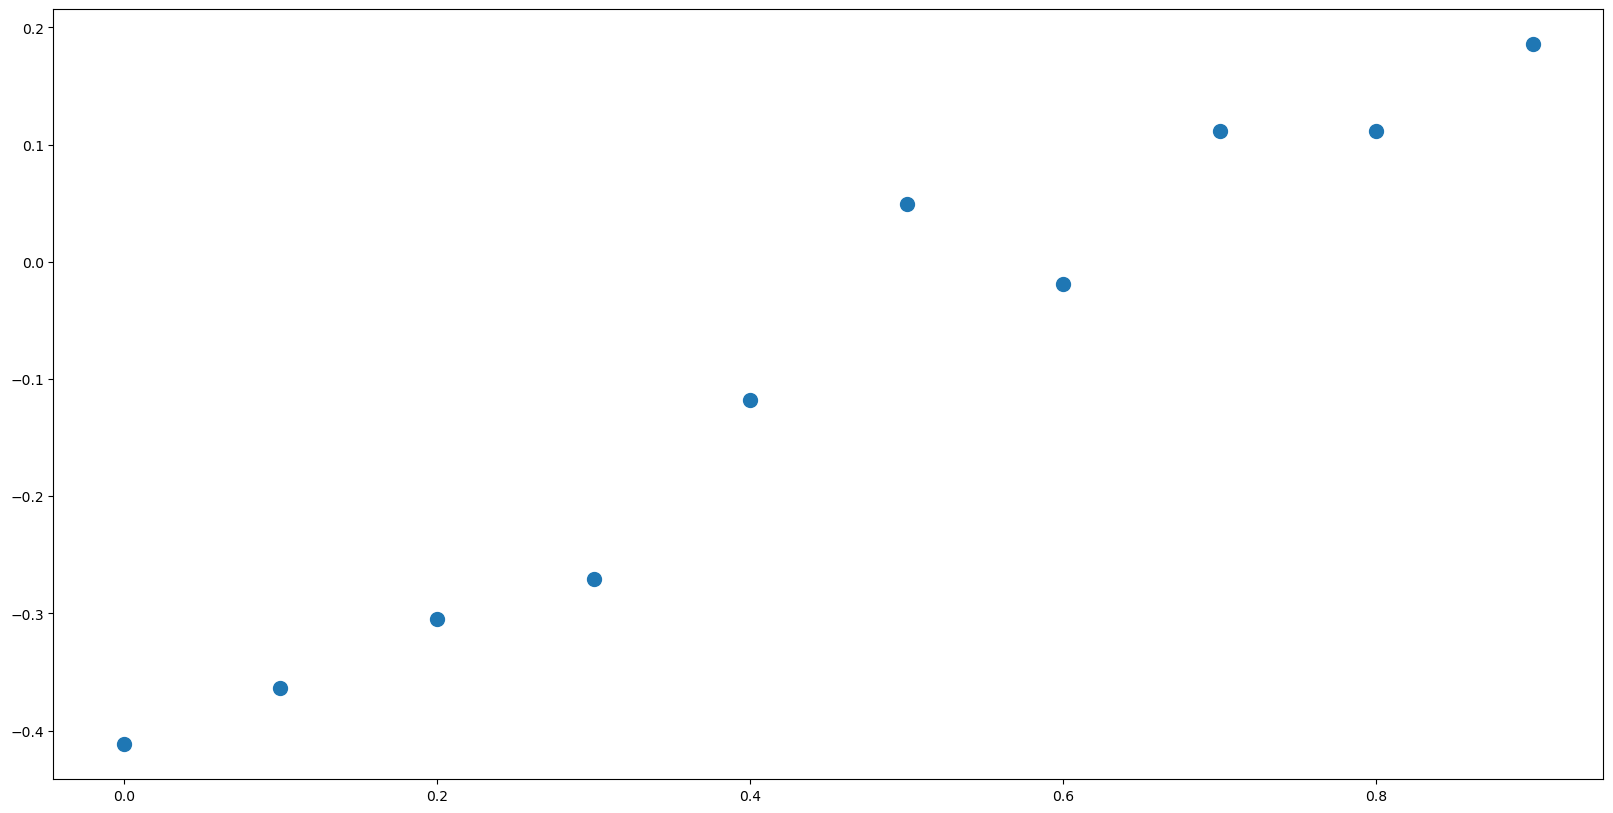

In [9]:
rng = np.random.RandomState(20)
xp = np.arange(0,1,0.01)
yp = -(xp-1)*(xp+1)*(xp-0.5)+0.1*rng.randn(len(xp))


x_train = xp[::10]
y_train = yp[::10]


x_test = xp[3::10]
y_test = yp[3::10]

plt.figure(figsize=(20,10))
plt.plot(x_train,y_train,'o', ms=10)
plt.show()

* Zobaczmy jak będą wyglądały wielomiany coraz wyższych stopni fitowane do dancyh treningowych i jakie współczynniki są dobierane:

 
-0.1029


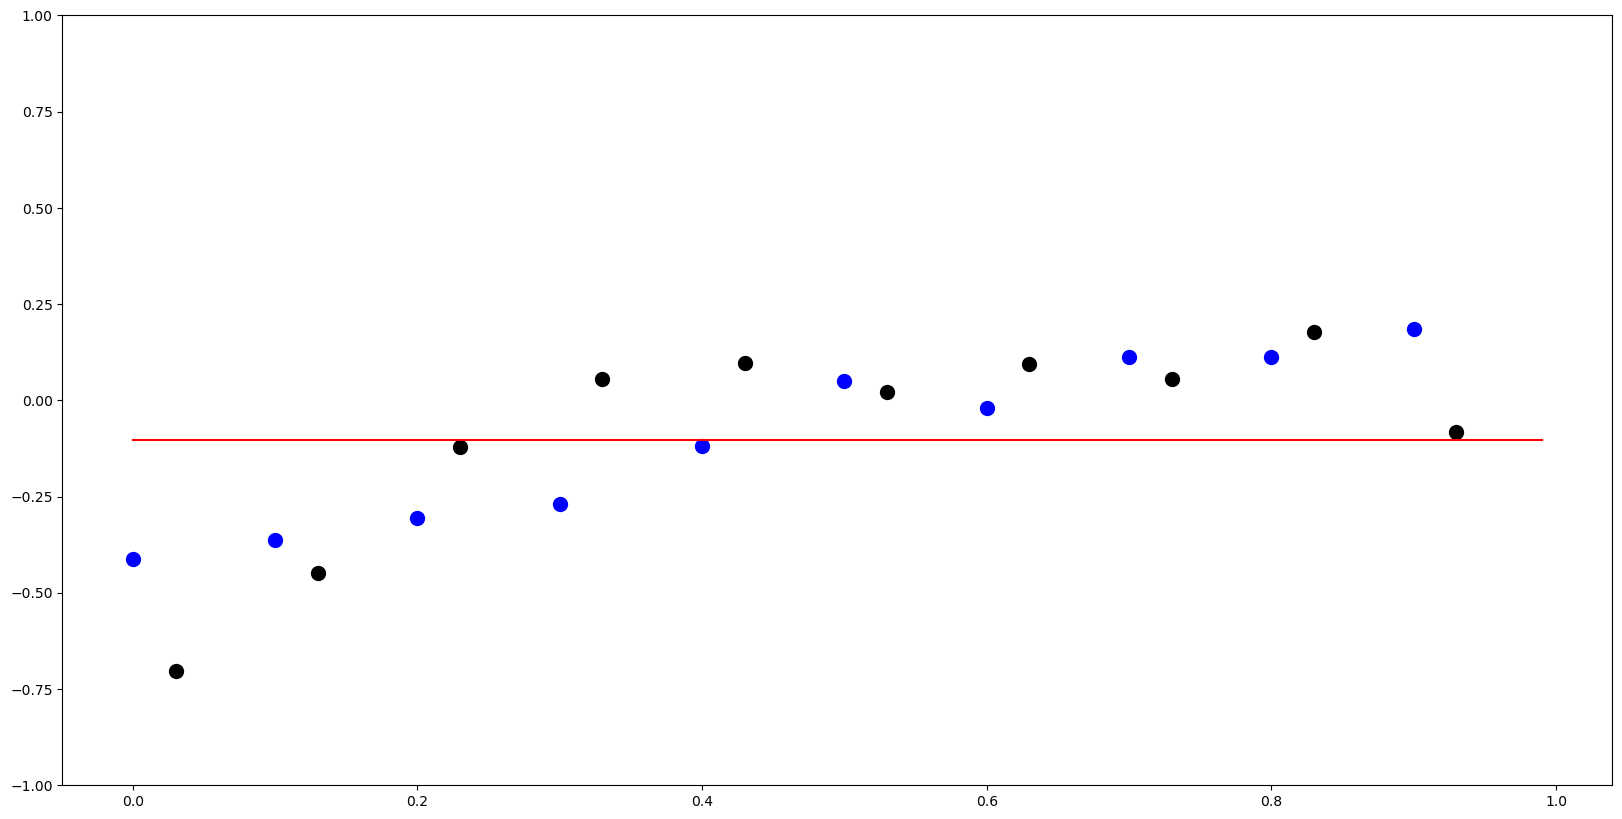

 
0.7096 x - 0.4222


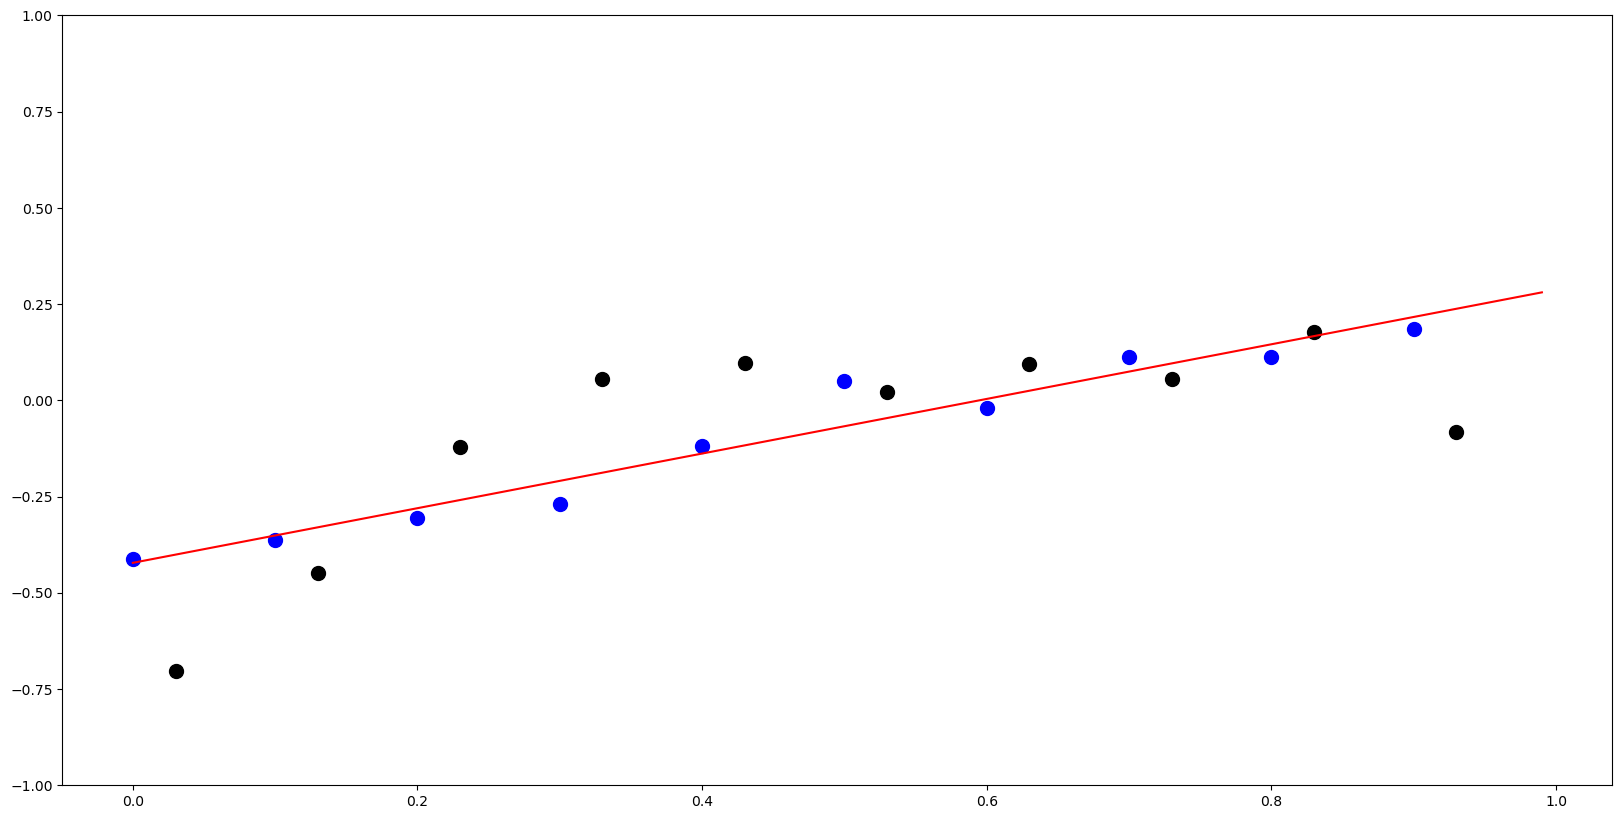

         2
-0.1988 x + 0.8885 x - 0.4461


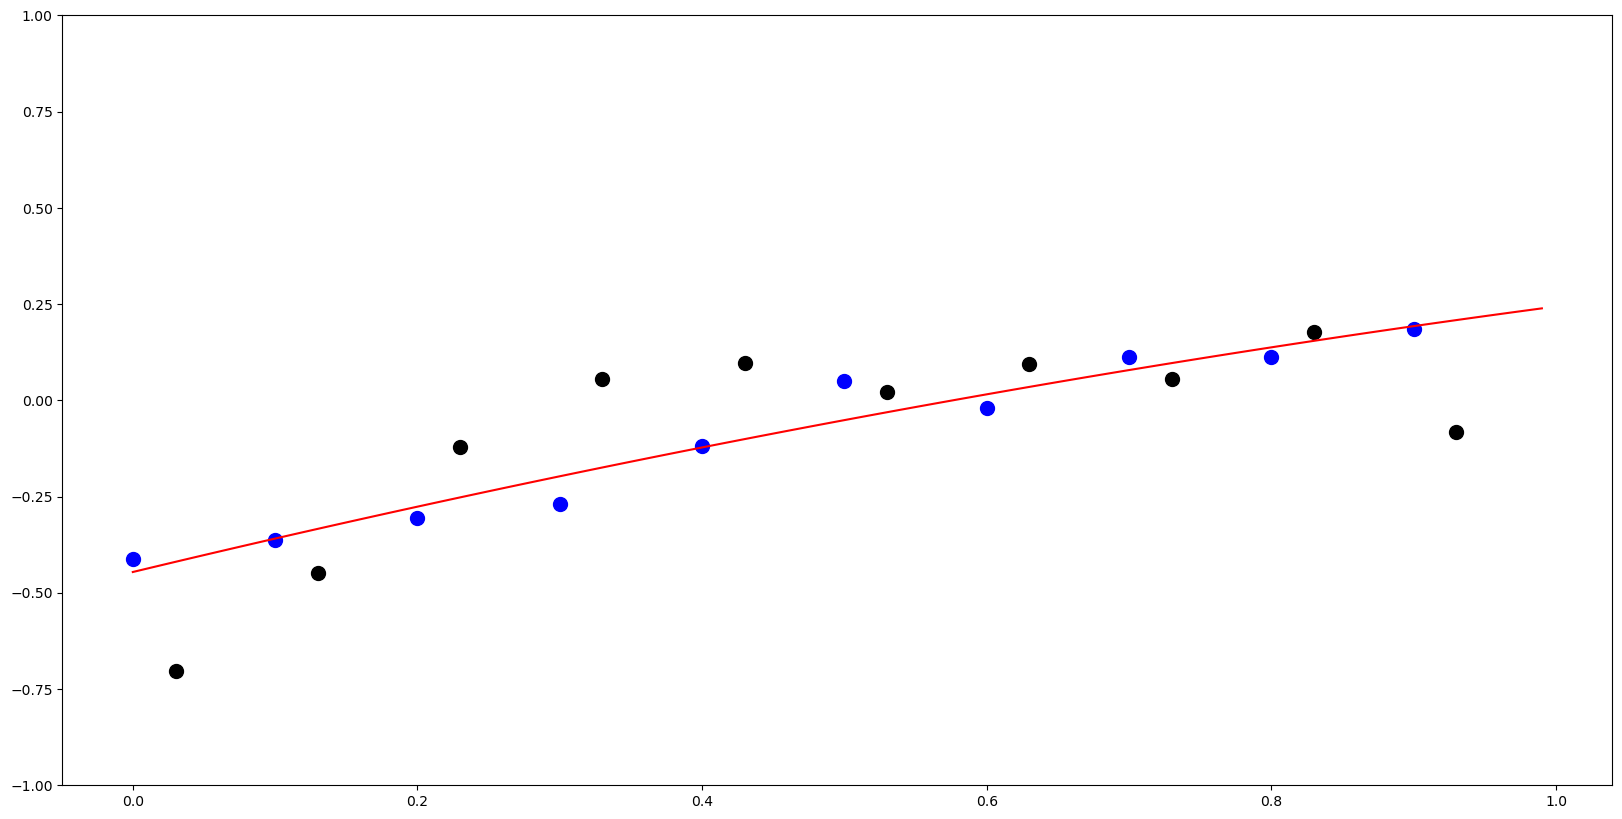

       3         2
-1.16 x + 1.367 x + 0.3539 x - 0.4168


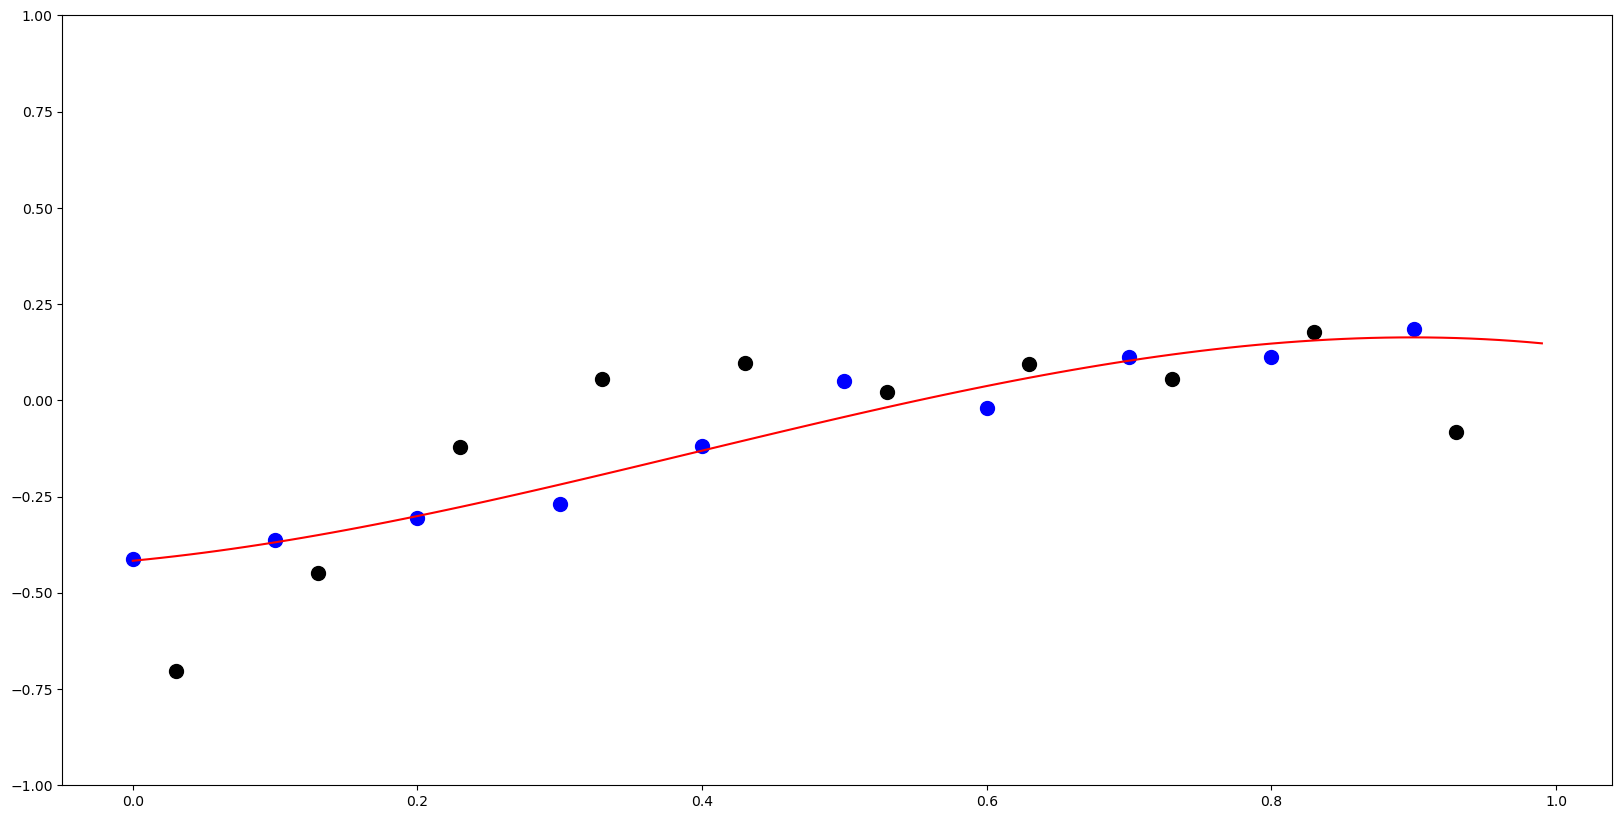

       4         3         2
3.862 x - 8.111 x + 5.267 x - 0.3412 x - 0.4002


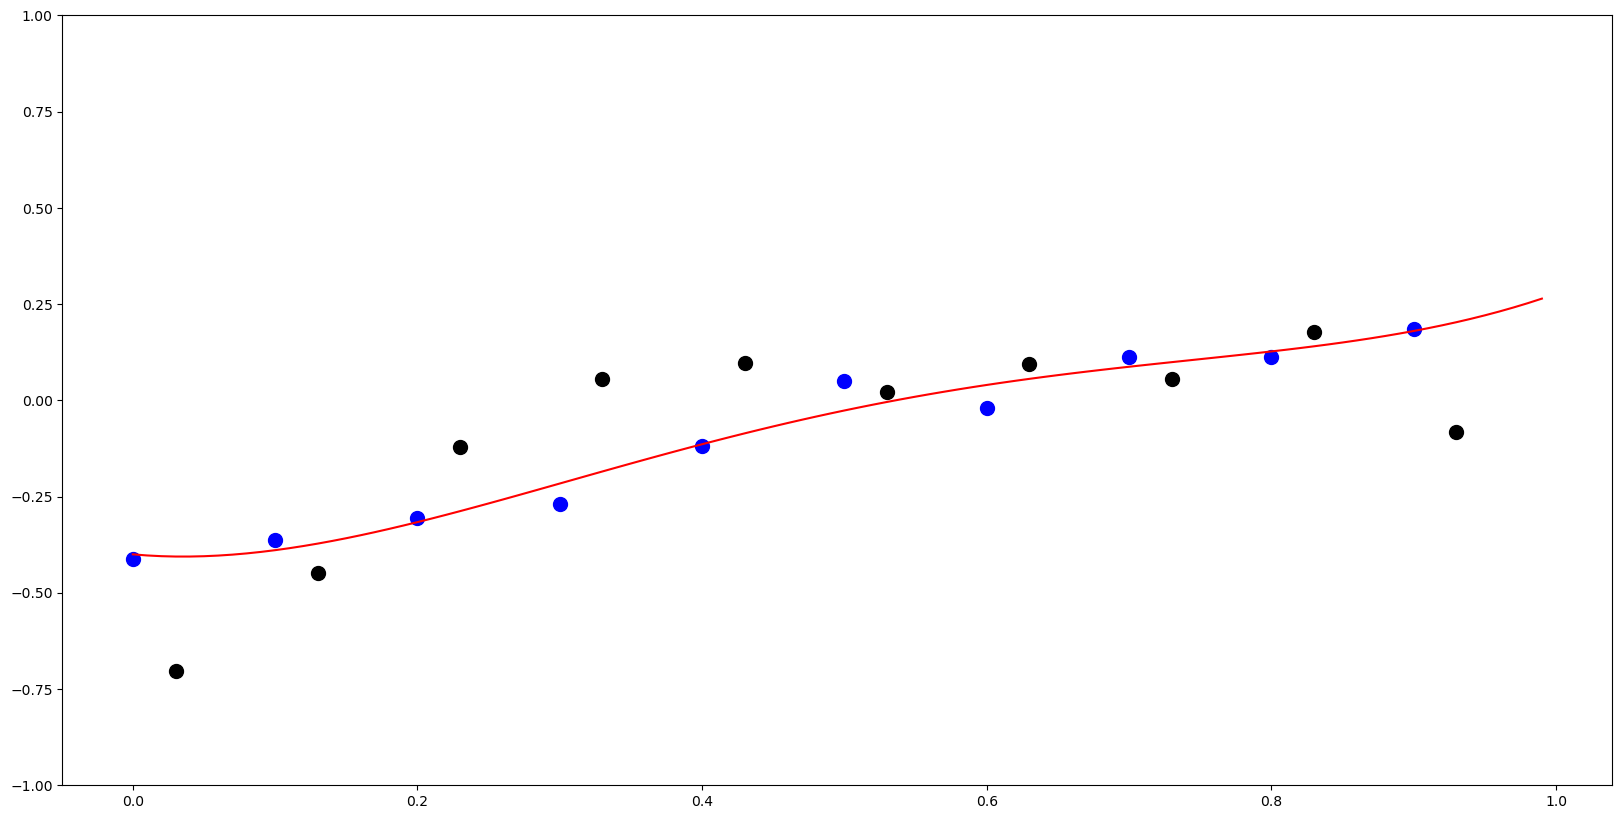

       5         4         3         2
14.29 x - 28.29 x + 17.14 x - 2.771 x + 0.5267 x - 0.4087


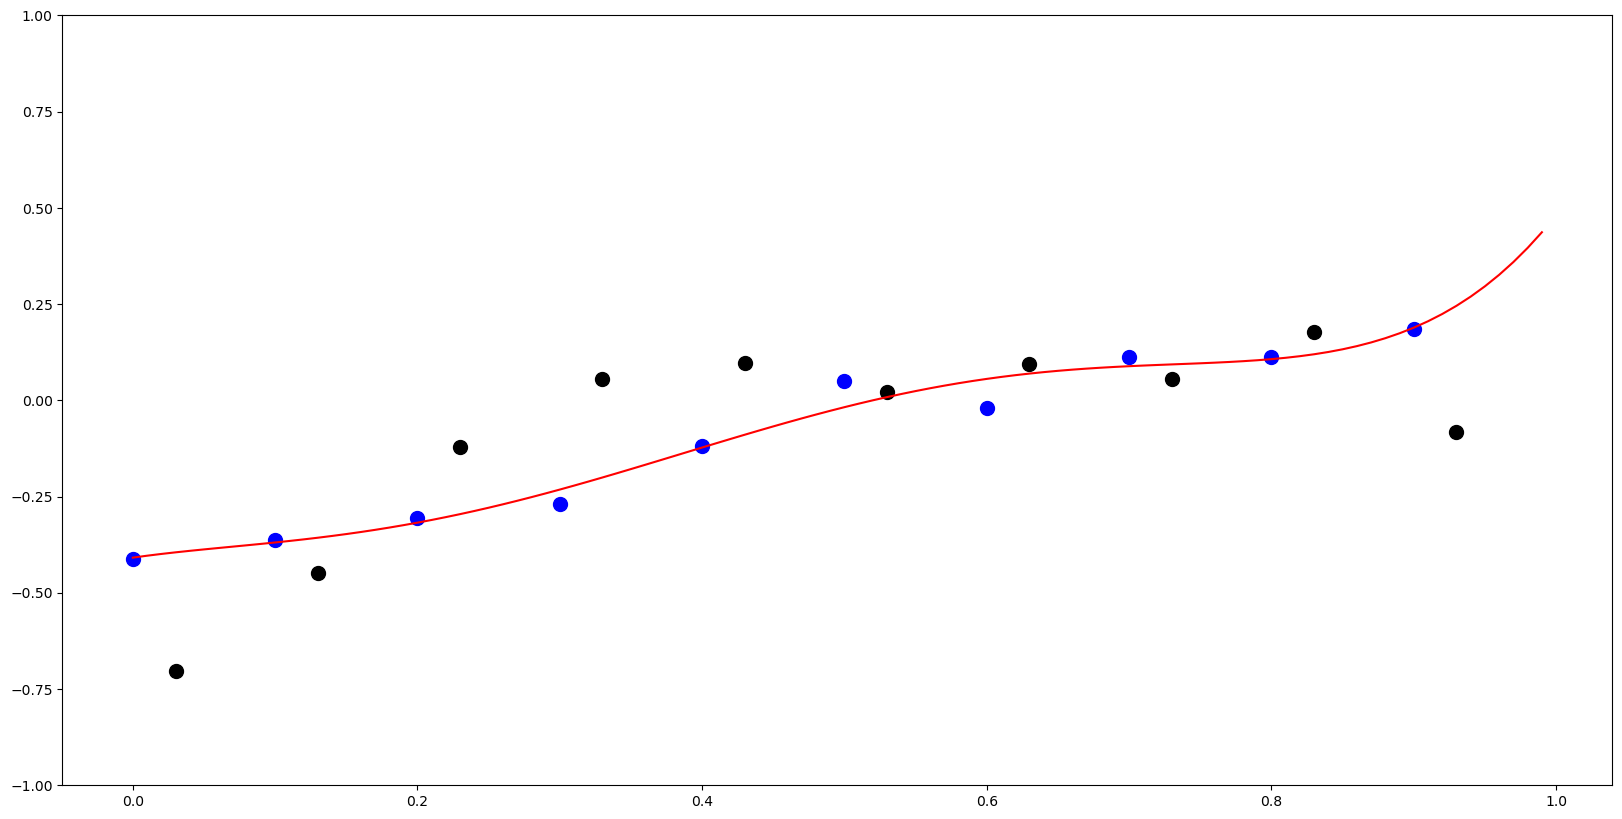

        6         5       4         3         2
-71.27 x + 206.7 x - 223 x + 107.8 x - 21.73 x + 1.91 x - 0.4134


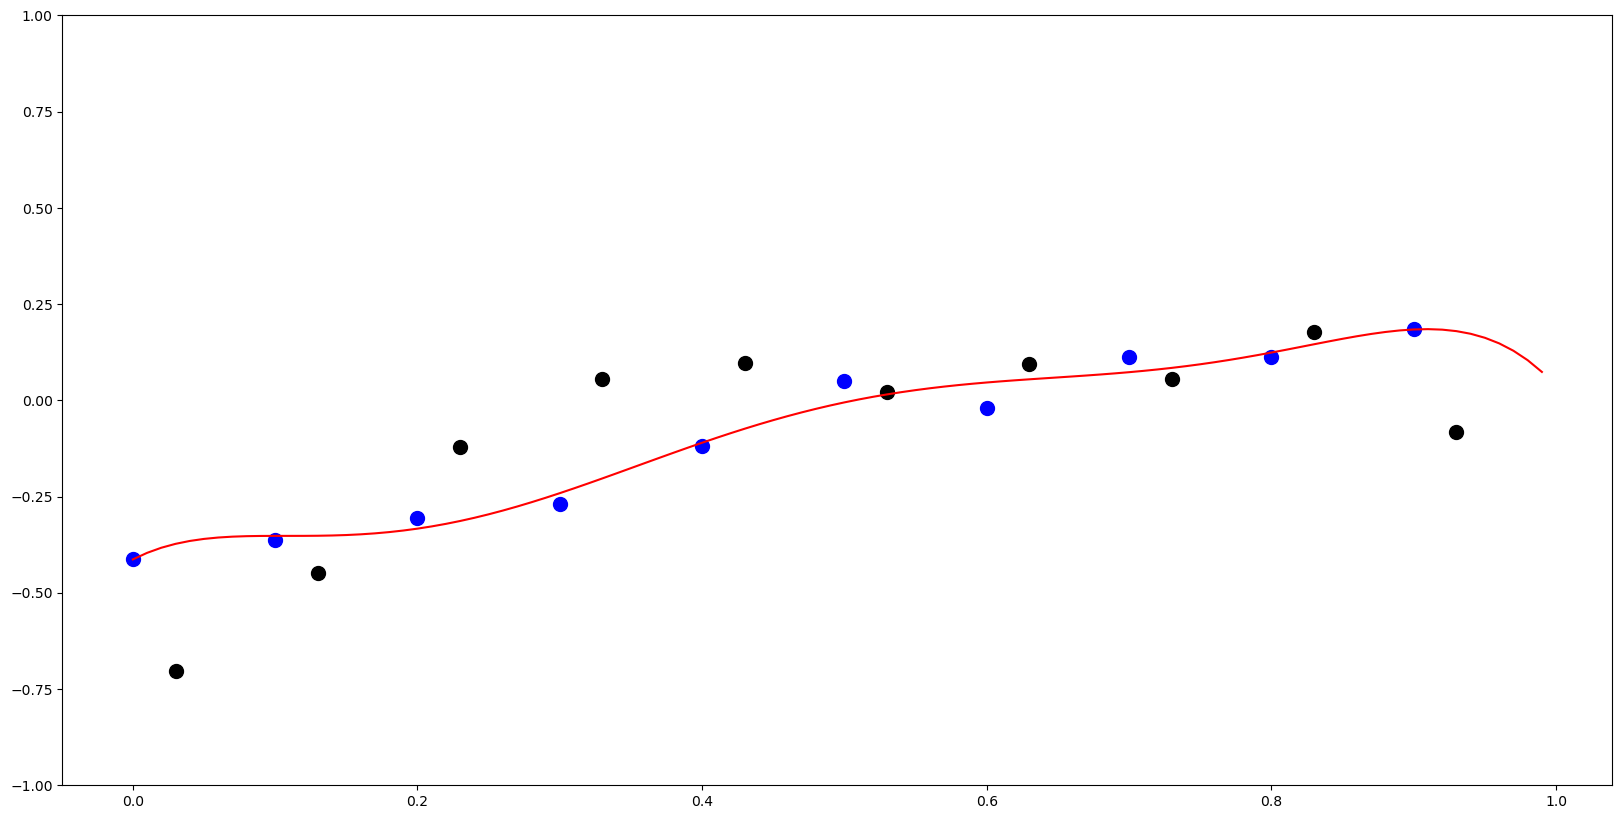

        7         6         5         4         3         2
-62.22 x + 124.7 x - 36.35 x - 72.98 x + 60.07 x - 14.49 x + 1.515 x - 0.4131


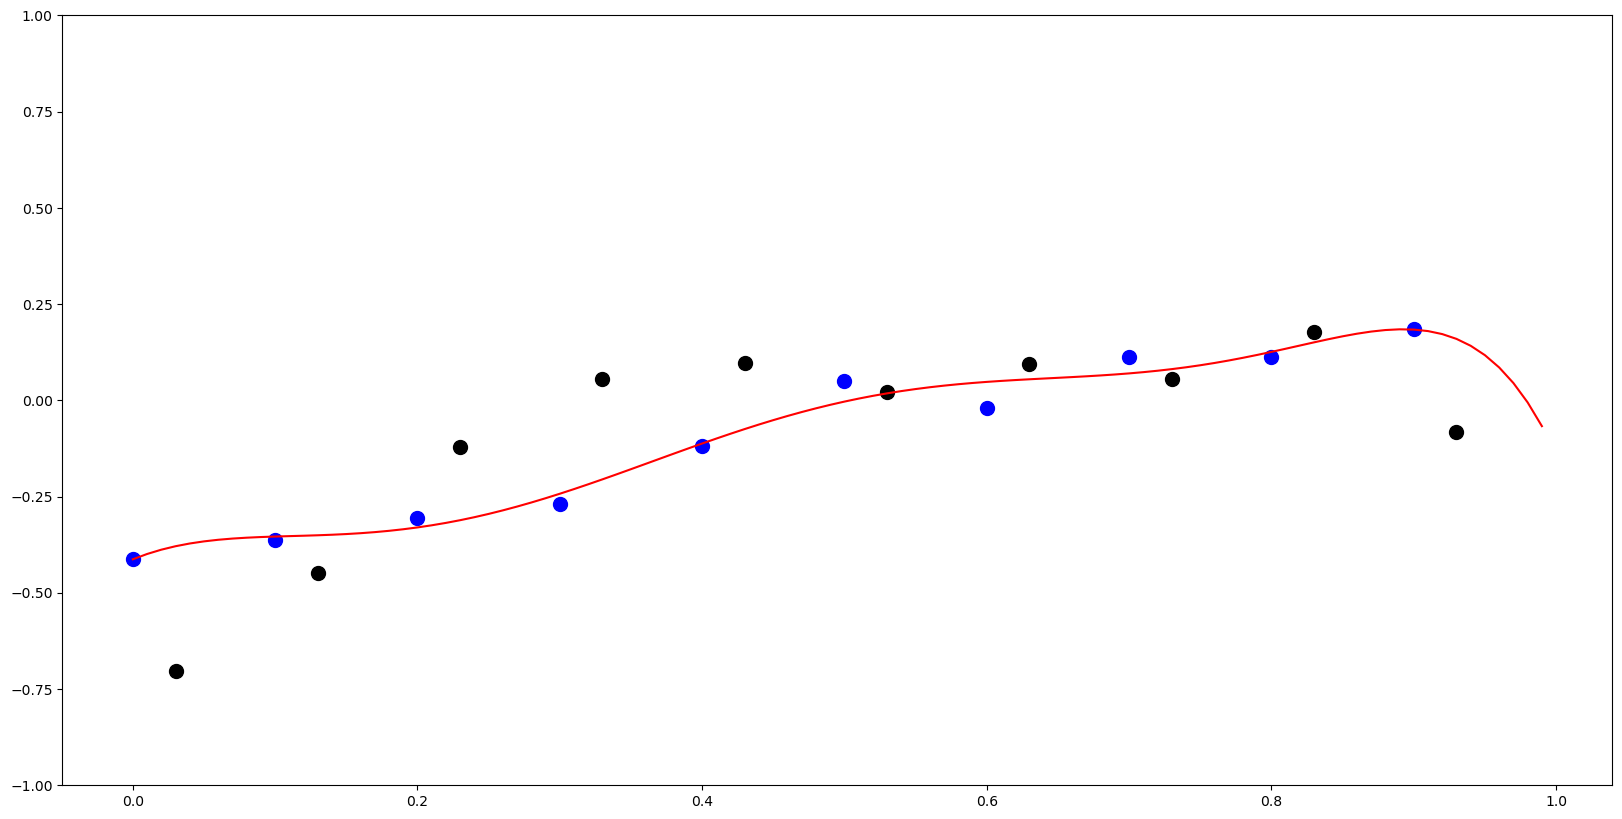

      8             7             6             5             4
5979 x - 2.159e+04 x + 3.177e+04 x - 2.445e+04 x + 1.048e+04 x
         3         2
 - 2457 x + 285.9 x - 11.89 x - 0.4114


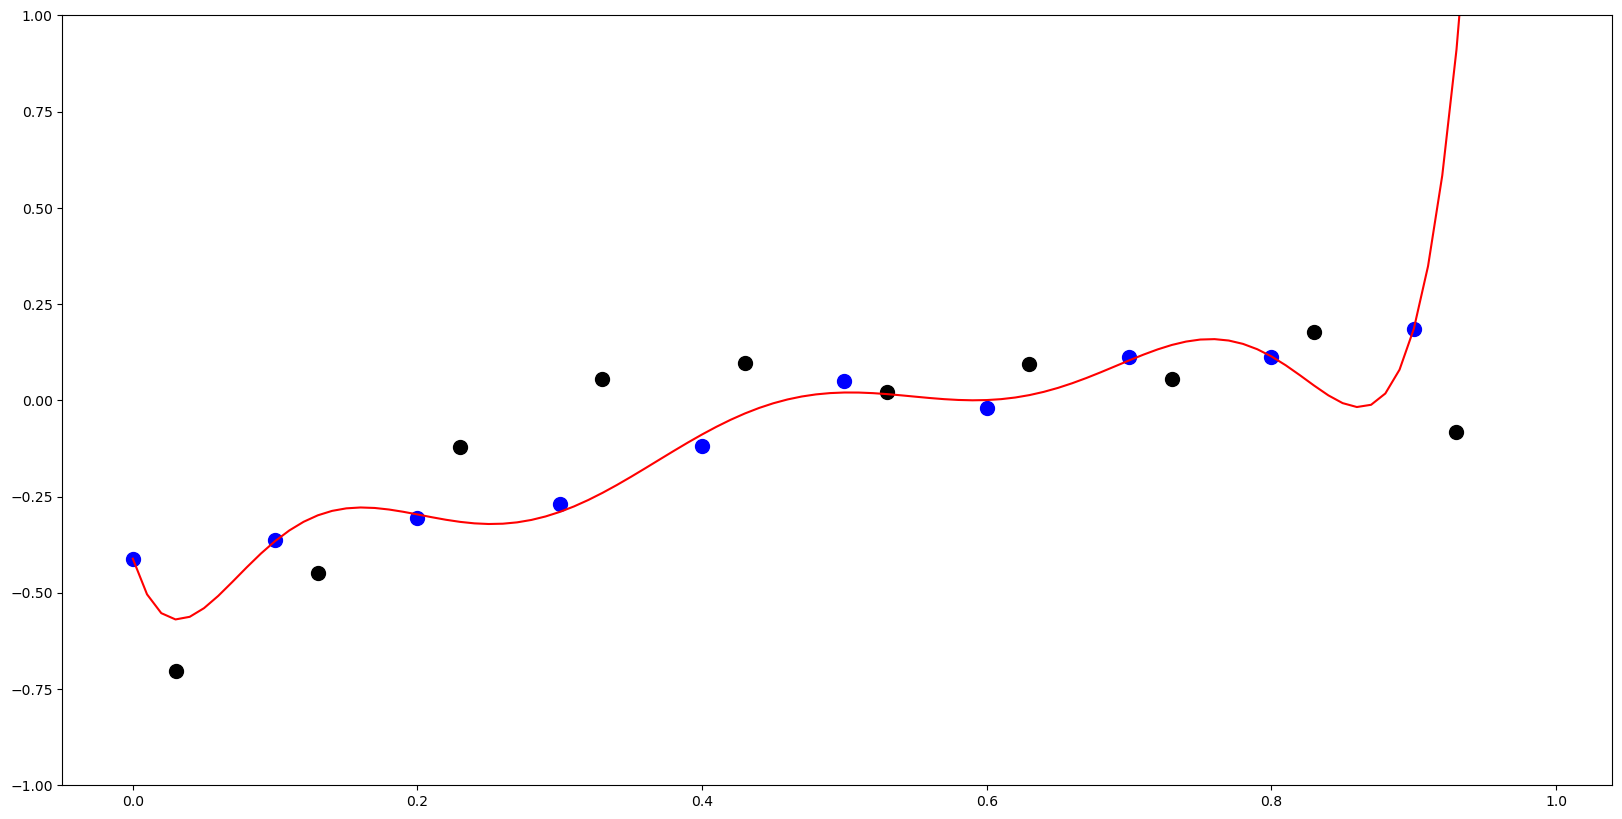

           9             8             7             6             5
3.099e+04 x - 1.195e+05 x + 1.919e+05 x - 1.663e+05 x + 8.444e+04 x
              4        3         2
 - 2.549e+04 x + 4434 x - 402.7 x + 14.94 x - 0.4116


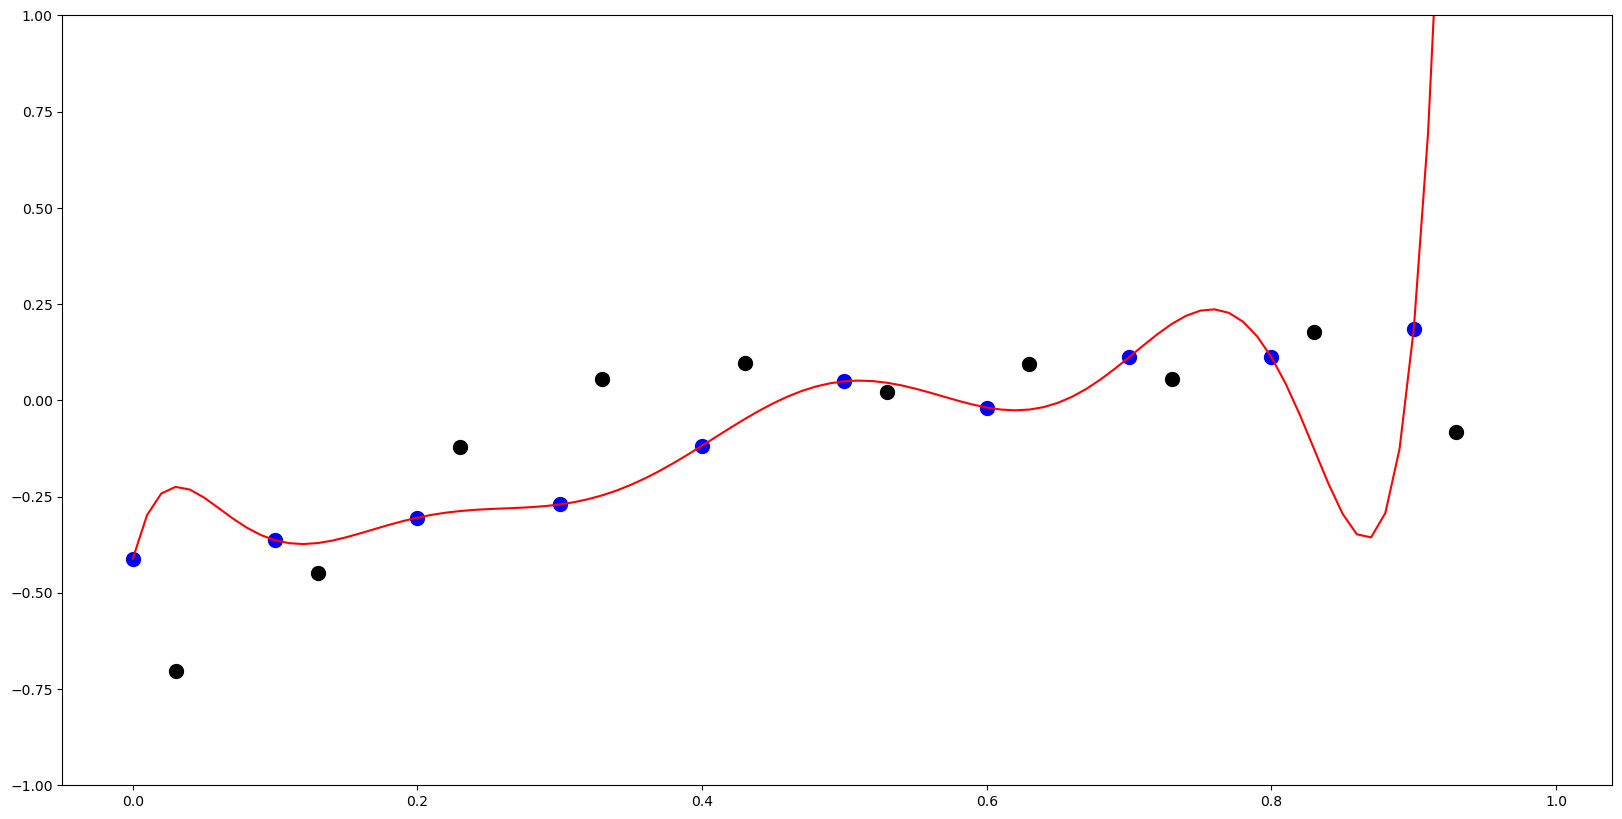

In [5]:
for p in range(len(y_train)):
    p_fit = np.poly1d(np.polyfit(x_train, y_train, p))
    plt.figure(figsize=(20,10))
    plt.plot(x_train,y_train,'bo',ms =10)
    plt.plot(x_test,y_test,'ko',ms =10)
    
    yp_fit = p_fit(xp)
    plt.plot(xp, yp_fit, 'r-')
    plt.ylim(-1.,1.)
    
    print(p_fit)
    plt.show()

Zauważmy dwa fakty:
* wraz ze wzrostem stopnia wielomianu dofitowana
  * linia przebiega coraz bliżej punktów treningowych
  * ale pojawiają się "dzikie" oscylacje sprawiające, że punkty ze zbioru testowego mogą znaleźć się bardzo daleko od wykresu dopasowanej funkcji
* wartość bezwzględna współczynników rośnie

Zobaczmy jak wygląda funkja błędu średniokwadratowego na zbiorze treningowym i testowym:

In [6]:
def mse(y,y_fit):
    return np.mean((y - y_fit)**2)

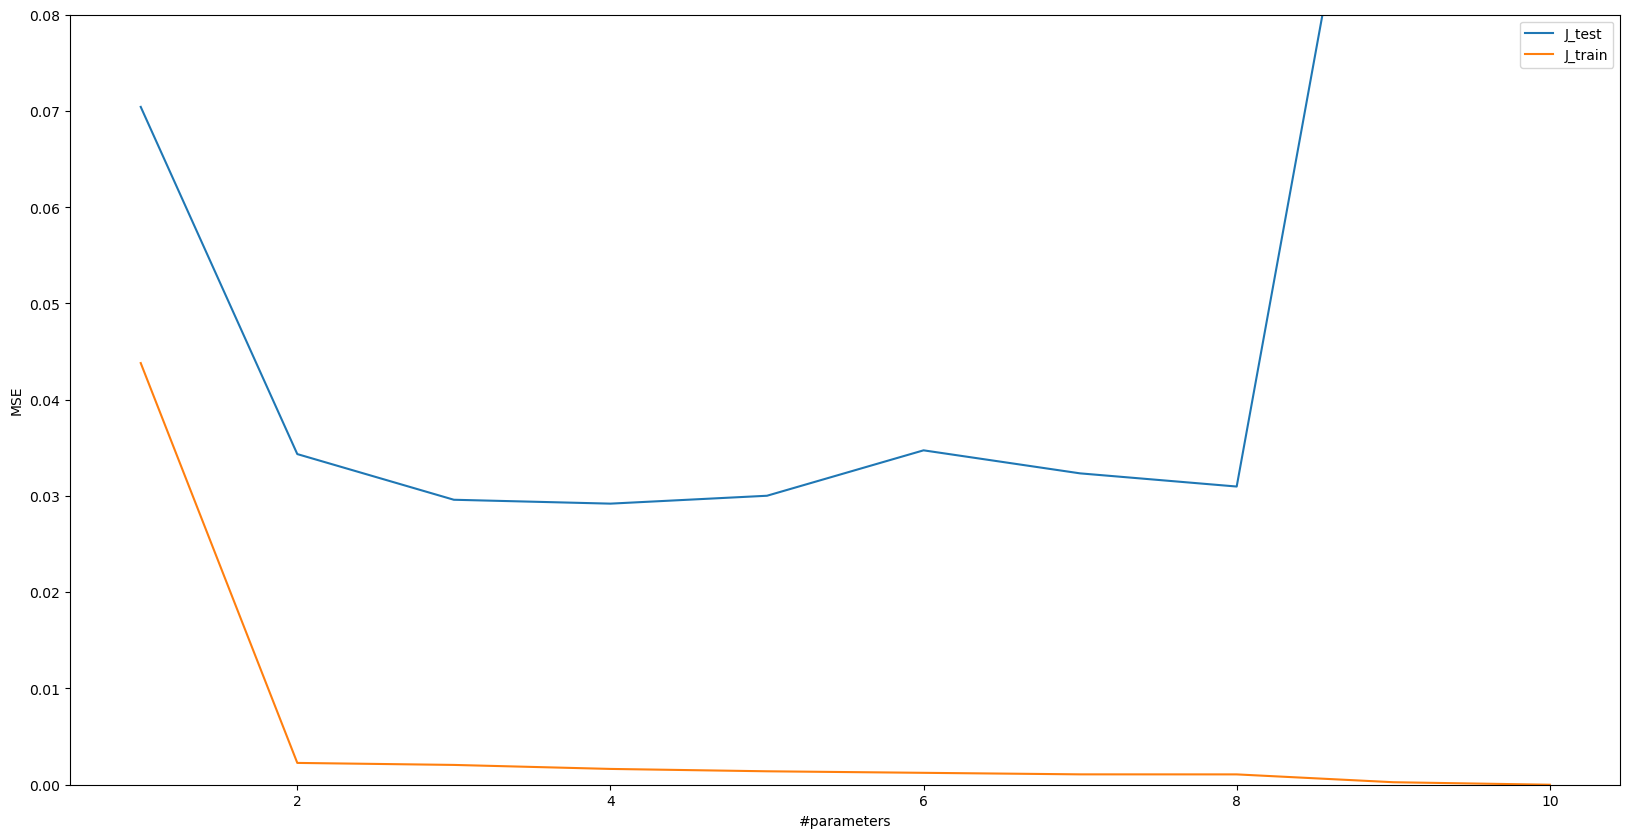

In [7]:
p_range = np.arange(0,len(y_train))

J_train = np.zeros(len(p_range))
J_test = np.zeros(len(p_range))

for p in p_range:
    p_fit = np.poly1d(np.polyfit(x_train, y_train, p))
    
    y_test_fit  = p_fit(x_test)
    J_test[p] = mse(y_test, y_test_fit)
    
    y_train_fit = p_fit(x_train)
    J_train[p] = mse(y_train, y_train_fit)
plt.figure(figsize=(20,10))
plt.plot(p_range+1, J_test, label = 'J_test')
plt.plot(p_range+1, J_train, label = 'J_train')
plt.ylim(0,0.08)
plt.legend()
plt.xlabel('#parameters')
plt.ylabel('MSE')


plt.show()

# Uogólnijmy te obserwacje

<img src="https://drive.google.com/uc?id=1HiKIfIjjgd0xZmYlfde_pwyWM7GlByZR">



![]("https://drive.google.com/uc?id=1HiKIfIjjgd0xZmYlfde_pwyWM7GlByZR")

# Czy można coś zrobić z nadmiernym dopasowaniem?

# Regularyzacja
Polegają one na dodaniu kary do funkcji kosztu:
$$ J(\theta) = \frac{1}{2} \sum_j(h_{\theta}(x^{(j)}) - y^{(j)})^2 + \underbrace{\lambda R(\theta)}_{\mathrm{kara}}$$

Często stosowane funkcje kary to:
- $R(\theta) = ||\theta||_2^2 = \sum \theta^2$ - ridge 
- $R(\theta) = |\theta|_1 = \sum |\theta|$ - lasso 
- $R(\theta) = \lambda_1 ||\theta||_2^2 + \lambda_2 |\theta|$ - sieci elastyczne

<img src="https://drive.google.com/uc?id=1HgeBgl6BsOtDtTIVtIaxdlwo-Hw0Qeem" width = 1000px>

Spróbujmy wyrobić sobie pewną intuicję o regularyzacji ridge:

W algorytmach optymalizacyjnych liczymy zwykle gradient f. kosztu:
$\nabla J_{reg} = \nabla J + 2 \lambda \theta$

po czym uaktualniamy parametry proporcjonalnie do niego, tylko w przeciwnym kierunku:

$\theta := \theta - \eta \nabla J_{reg} = \theta - \eta\nabla J - 2 \lambda \eta \theta = \underbrace{(1-2\eta \lambda)}_{weight \, decay} \theta - \eta \nabla J$ 

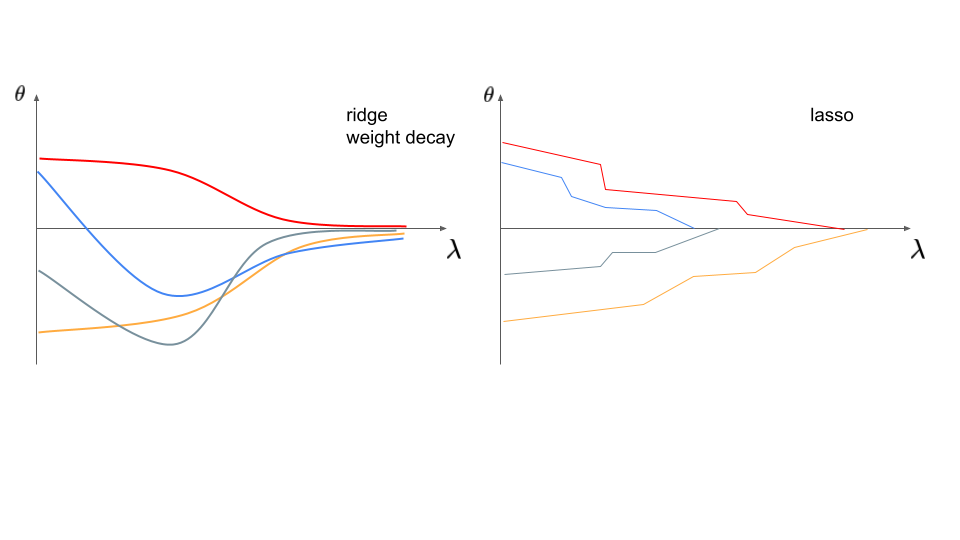

<img src = "https://drive.google.com/uc?id=1Hj9o_jDuCmqqIItDwIu41RWobCyECH5h" width = 1000px>

Nieco wglądu dlaczego możemy spodziewać się takiego zachowania parametrów modelu wraz z nasilaniem regularyzacji dostarcza przepisanie go na postać problemu optymalizacyjnego z więzami:
- ridge
$$J_{reg}(\theta) = J (\theta) + \lambda ||\theta||_2^2 \rightarrow \min_{\theta} J(\theta) \quad
p.w. ||\theta||_2^2 \le t$$

- lasso
$$J_{reg}(\theta) = J (\theta) + \lambda |\theta|_1 \rightarrow \min_{\theta} J(\theta) \quad
p.w. |\theta|_1 \le t$$

<img src = "https://drive.google.com/uc?id=1Hif_UbbbCjmPyfXkA0bFig1zXDds7oJX" width = 1000px>

## Bagging i boosting


Pomyślmy jeszcze raz o drzewach decyzyjnych

<img src="https://drive.google.com/uc?id=1Hkt-2AuOBWhVp5fSZ6wHs03eyShZsTxV" width = 1000px>

<img src="https://drive.google.com/uc?id=1HlpR3PcG0Rc3hijG4D243M4juioX5lS1" width = 1000px>

<img src="https://drive.google.com/uc?id=1HmYtmEvxX9c2-_PIr3fuuXZfZojopzVk" width = 1000px>

Rozbudowując to drzewo możemy doprowadzić do idealnej klasyfikacji zbioru treningowego.

<img src="https://drive.google.com/uc?id=1HiKIfIjjgd0xZmYlfde_pwyWM7GlByZR" width = 1000px>

<img src="https://drive.google.com/uc?id=1HkVruNij5B89djVf-aIDHv32I4RTneou" width = 1000px>

Boosting w ogólności polega na:
* zastosowaniu wielu słabych klasyfikatorów
* kolejne klasyfikatory są trenowane tak aby zwracać większą uwagę na próbki źle sklasyfikowane przez poprzedni model

Na obrazkach wygląda to tak:

<img src="https://drive.google.com/uc?id=1HmluTk0Fearig8WVTu9qdP9RJ7UMt2Yb" width = 1000px>

<img src="https://drive.google.com/uc?id=1HnqN8Jdh9IuSrCjjU4BPO9UPNOmmLPUj" width = 1000px>

<img src="https://drive.google.com/uc?id=1Ho53shwPrMc8hg3Fe8yQaUyfb40a2QbL" width = 1000px>

Algorytm wygląda zatem następująco:
* Każdy przykład w zbiorze treningowym ma wagę. Na początku wszystkie wagi są równe $w_i = \frac{1}{n}$

* Powtarzaj dla kroków $m = 1, \dots, M$
  * Fituj klasyfikator $h_m$ do danych z wagami $w_i$
  * Oblicz wagę tego modelu $\alpha_m$ biorąc pod uwagę jego dokładność
  * uaktualnij $w_i$ zwiększając wagi źle sklasyfikowanych przykładów

Poszczególne modele $h_m$ będą raczej podobnie złe, ale każdy będzie w swojej klasyfikacji skupiał się na innych fragmentach zbioru treningowego. 

Modele te są następnie uśredniane z wagami i ostateczne wyjście z modelu całościowego ma postać (przy założeniu, że klasy kodowaliśmy $y \in \{ -1, 1\}$):

$$ h(x) = \mathrm{sign} \left( \sum_m \alpha_m h_m(x) \right)$$

Szczególnym, popularnym, algorytmem dobierania wag modeli i modyfikowania wag przykładów jest Ada Boost.

Obliczamy błąd:
$$ err_m = \frac{\sum w_i 1\{y_i \ne h_m(x_i)\} }{\sum w_i} $$

Obliczamy wagę modelu:

$$\alpha_m = \log \frac{1-err_m}{err_m} $$

Aktualizujemy wagi przykładów:

$$w_i := w_i \exp \left(\alpha_m 1 \{y_i \ne h_m(x_i)\}\right)$$

(dla $h$ wyjątkowo złego $err_m =0.5$ -> jak to wpływa na $\alpha$ i na wagi? a jka dla modelu nieco lepszego $err_m < 0.5$)

* w Ada Boost liczba prostych modeli składowych stanowi o złożoności modelu całościowego
* teoretycznie możliwe jest overfitowanie, ale w praktyce obserwuje się je bardzo słabe wraz ze wzrostem liczby modeli
* dostatecznie długie boostowanie prowadzi do 100% dokładności na zbiorze treningowym

# Bagging

Ta metoda korzysta z uśredniania złożonych modeli (potencjalnie overfitujacych), ale uczonych na bootstrapowanych danych
* co to jest bootstrap?

> bootstrap - procedura losowania elementów zbioru ze zwracaniem. Zbiory bootstrapowane mają ten sam rozmiar co zbiór oryginalny. 

Zatem bagging możemy zapisać w następujący sposób:
$$ h(x) = \frac{1}{B} \sum_{b=1}^{B} h_b(x)$$
gdzie $h_b(x)$ jest modelem uczonym na zbiorze bootstrapowanym $b$

Uśrednianie prowadzi do zmniejszania się wariancji (przeuczenia) końcowego modelu.

<img src="https://drive.google.com/uc?id=1HkVruNij5B89djVf-aIDHv32I4RTneou" width = 1000px>

<img src="https://drive.google.com/uc?id=1HovA6n4GpL3JtNhu7k8GmtWqomU_UE7N" width = 1000px>

# Las losowy (random forest)
* pojedyncze drzewo jest podatne na szum w zbiorze uczącym i mimo powyższych technik może się przeuczać
* pomysłem jest konstrukcja wielu drzew różniących się nieco od siebie i uśrednianie ich wyniku 
 * pierwsze miejsce randomizacji to zastosowanie podzbioru zbioru uczącego -> bootstrap danych -> trenujemy drzewa na różnych zbiorach danych (jak bagging)
 * drugie miejsce randomizacji to zastosowanie podzbioru losowo wybranych $m$ spośród wszystkich możliwych $p$ cech do podziału w danym węźle, $m <<p$, często $m=\sqrt{p }$
 
* ze względu na porcedurę bootstrapu można w proces uczenia lasu wbudować CV - dane, które nie weszły w w danym bootstrapie $b$ do zbioru treningowego można wykorzystać jako dane testowe.

Klasyfikacja nowego przykładu za pomocą lasu losowego polega np. na przyjęciu za klasę wyjściową tą klasę, którą zwraca największa liczba drzew w lesie.

Wspomnianą wcześniej technikę szacowania istotności cech można rozszerzyć na lasy losowe.

# Skalowanie
* algorytmy wymagające losowego dostępu do danych-> dane powinny mieścić się w pamięci
* algorytmy wymagające sekwencyjnego dostępu do danych, po każdym przejściu przez dane aktualizujemy model: dane mogą byś zapisane na dysku  (SPRINT, SLIQ)
* algorytmy działające na strumieniu danych. Założenie jest takie, że algorytm może skorzystać z danych tylko raz (VFDT - very fast decision tree).

# Podsumowanie:
* drzewa jako algorytm "White box"
* rekurencyjne hodowanie drzew
* jak poradzić sobie z przeuczaniem?
